In [1]:
! git clone https://www.github.com/DS3001/group15

Cloning into 'group15'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 140 (delta 43), reused 5 (delta 3), pack-reused 58
Receiving objects: 100% (140/140), 4.47 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.model_selection import RepeatedKFold,GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

In [3]:
df_train = pd.read_csv('/content/group15/Project_2/training_cleaned.csv')
df_test = pd.read_csv('/content/group15/Project_2/testing_cleaned.csv')

y_train = df_train['stroke']
X_train = df_train.drop('stroke', axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke', axis=1)

Notes from Visualization:
hypertension, smoking status, heart disease, gender, age -- seem to be the most influencial variables. First step is to check using KMC

# KMC

In [14]:
#ffc is 'features for clustering'
#dfc is 'data for clustering'
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['gender'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)

ffc = ['age', 'heart_disease', 'hypertension', 'stroke'] # I included stroke so i can see how the clusters vary in their stroke presence
dfc = pd.concat([df_train[ffc], dummies], axis=1)

num_clusters = 5 # number of clusters to look at

kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(dfc) # fit the model

# get cluster centers
cluster_centers = kmeans_model.cluster_centers_

# create a dataframe to display
cluster_centers_df = pd.DataFrame(cluster_centers, columns=dfc.columns)

print("Cluster Centers:")
print(cluster_centers_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
         age  heart_disease  hypertension    stroke  Never_worked   Private  \
0  26.387728       0.001305      0.011749  0.001305  3.916449e-03  0.832898   
1  75.246246       0.183183      0.238739  0.156156 -1.431147e-17  0.489489   
2  42.829405       0.013468      0.060606  0.016835 -1.604619e-17  0.672278   
3   8.654281       0.001513      0.001513  0.001513  1.815431e-02  0.157337   
4  57.912076       0.068856      0.152542  0.052966 -1.561251e-17  0.604873   

   Self-employed      children     Urban      Male         Other  \
0       0.062663  6.106227e-16  0.497389  0.343342  1.305483e-03   
1       0.388889  6.106227e-16  0.510511  0.399399 -1.626303e-19   
2       0.138047  6.383782e-16  0.499439  0.362514 -1.192622e-18   
3       0.016641  7.987897e-01  0.491679  0.527988 -1.084202e-19   
4       0.205508  6.383782e-16  0.508475  0.433263 -1.246832e-18   

   formerly smoked  never smoked    smokes  
0         0.120104      0.453003  0.187990  
1        

Age, heart disease, hypertension, gender (from visualization), urban,  and smoking seem to be the biggest indicators.

# Linear Regression Model

In [56]:
X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease'] ] # most important numeric variables

expander = PolynomialFeatures(degree=2,include_bias=False) # expander
Z = expander.fit_transform(X_train_numeric)
names = expander.get_feature_names_out()
continuous = pd.DataFrame(data=Z, columns = names)

dummies_train = pd.concat([ pd.get_dummies(X_train['gender'],dtype='int',drop_first=True), # dummy vars for categorical
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)

Z_train = pd.concat([continuous,dummies_train],axis=1)

#repeat training process for test

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease'] ]
expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(X_test_numeric)
names = expander.get_feature_names_out()
continuous = pd.DataFrame(data=Z, columns = names)

dummies_test = pd.concat([ pd.get_dummies(X_train['gender'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)

Z_test = pd.concat([continuous,dummies_test],axis=1)

# fit the model
reg = LinearRegression().fit(Z_train, y_train)

# get R2 and RMSE
print('R2: ', reg.score(Z_test, y_test)) #R2
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   #RMSE

R2:  0.08404350589545528
RMSE:  0.19529206457263773


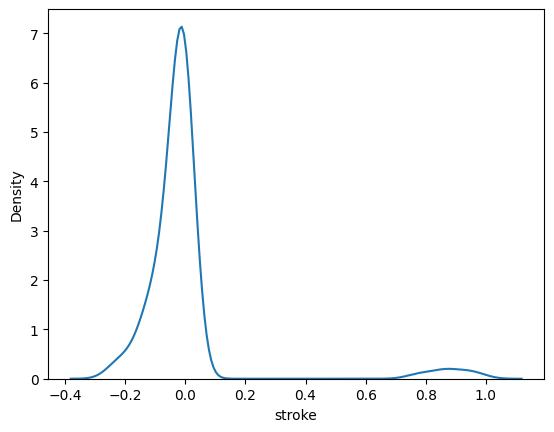

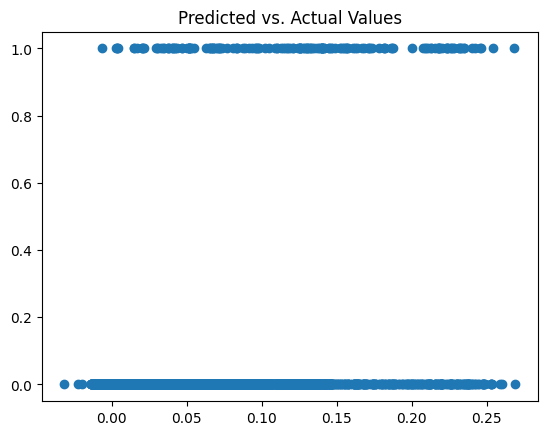

In [29]:
# predicted values:
y_hat_lm = reg.predict(Z_test)
residuals_lm = y_test - y_hat_lm

# residual plot:
sns.kdeplot(residuals_lm)
plt.show()

# predicted vs actual
plt.scatter(x=y_hat_lm, y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

These variables on a Linear Model provided a smaller RMSE value than the example given in the write up. To me, this indicates that weighing these specific variables yields better predictors.

# Decision Tree

In [67]:
# keeping same variables for decision tree model
X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease', 'bmi'] ]
expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(X_train_numeric)
names = expander.get_feature_names_out()
continuous = pd.DataFrame(data=Z, columns = names)


Z_train = expander.fit_transform(X_train_numeric)

# training setup
dummies_train = pd.concat([ pd.get_dummies(X_train['gender'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)

X_train_combined = pd.concat([pd.DataFrame(data=Z_train, columns=expander.get_feature_names_out()),
                              dummies_train], axis=1)

# testing setup
X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease', 'bmi'] ]
expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(X_test_numeric)

Z_test = expander.fit_transform(X_train_numeric)

dummies_test = pd.concat([ pd.get_dummies(X_train['gender'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)

X_test_combined = pd.concat([pd.DataFrame(data=Z_test, columns=expander.get_feature_names_out()),
                             dummies_test], axis=1)

# get kfold
kf =RepeatedKFold(n_splits=10,n_repeats =5, random_state=30)

scoring = {'r2': 'r2', 'neg_mean_squared_error': 'neg_mean_squared_error'}

param = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# get and fit decision tree
reg = DecisionTreeRegressor(random_state=42)
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')
model = search.fit(X_train_combined, y_train)

pred = model.predict(X_test_combined)

In [68]:
test_rmse = np.sqrt(mean_squared_error(y_test, pred))
test_r2 = r2_score(y_test, pred)
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)

Test RMSE: 0.1614282177720184
Test R2: 0.3741582137093671


Even lower test RMSE achieved! It was ~0.17, but then I added bmi on a whim and it lowered the RMSE down to 0.15. I then added ever_married for fun, but that raised the RMSE, so I took it out again.